In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import ray
import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.ddpg as ddpg
import ray.rllib.agents.ddpg.td3 as td3

import ray.rllib.agents.sac as sac
import seagul.envs
import numpy as np
from numpy import pi
import gym
from mpl_toolkits.mplot3d import Axes3D
#from simple_pid import PID

import dill
import pickle
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
%matplotlib inline

import pandas as pd

In [18]:
home_path = '/home/sgillen/work/'

checkpoint_path = home_path + \
"seagul/seagul/notebooks/lorenz/data/tune/custom_reward/TD3/TD3_linear_z-v0_62f49f48_2020-02-11_19-54-36bdjbw451/checkpoint_20/checkpoint-20"

In [19]:
# Some delightfully ugly python to infer where everything else is...
config_path =  '/'.join(checkpoint_path.split('/')[:-2]) + '/params.pkl'
config = dill.load(open(config_path, 'rb'))
env_name = config['env']

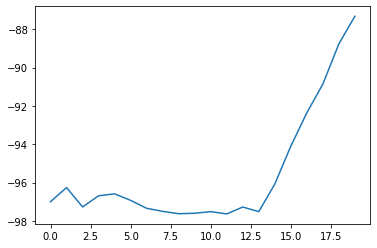

In [20]:
csv_path = '/'.join(checkpoint_path.split('/')[:-2]) + '/progress.csv'
df = pd.read_csv(csv_path)
plt.plot(df['episode_reward_mean'])

In [21]:
ray.shutdown()
ray.init()

# !! change this line to reflect the algorithm you used
#trainer = ppo.PPOTrainer(config)#, config['env_name'])
trainer = td3.TD3Trainer(config)
#trainer = ddpg.DDPGTrainer(config)
#trainer = sac.SACTrainer(config)

trainer.restore(checkpoint_path)

2020-02-11 20:22:00,718	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-11 20:22:00,720	INFO resource_spec.py:212 -- Starting Ray with 13.82 GiB memory available for workers and up to 6.92 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-11 20:22:01,306	INFO services.py:1093 -- View the Ray dashboard at localhost:8265
2020-02-11 20:22:02,674	WARNING actor.py:666 -- Actor is garbage collected in the wrong driver. Actor id = ActorID(45b95b1c0100), class name = RolloutWorker.
2020-02-11 20:22:02,751	WARNING trainable.py:210 -- Getting current IP.
2020-02-11 20:22:02,753	INFO trainable.py:416 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/seagul/seagul/notebooks/lorenz/data/tune/custom_reward/TD3/TD3_linear_z-v0_62f49f48_2020-02-11_19-54-36bdjbw451/checkpoint_20/checkpoint-20
2020-02-11 20:22:02,753	INFO trainable.py:423 -- Curr

In [62]:
#env = gym.make(env_name)
#env.unwrapped.reset_model = det_reset_model

# !! this needs to reflect the environemnt you trained in
env = gym.make(env_name, **config['env_config'])
#env._max_episode_steps = 100000
#env.state_noise_max = 5.0
obs = env.reset()
print(obs)

action_hist = []
m_act_hist = []
obs_hist = []
reward_hist = []

done = False

actions = np.array([10,0])



def reward_fn(s):
    if s[3] == 1:
        if s[0] > 2 and s[2] > 3:
            reward = 5.0
            s[3] = 0
        else:
            reward = -1.0

    elif s[3] == 0:
        if s[0] < -2 and s[2] < -3:
            reward = 5.0
            s[3] = 1
        else:
            reward = -1.0

    return reward, s

while not done:
#for _ in range(500):
    # for some algorithms you can get the sample mean out, need to change the value on the index to match your env for now
    # mean_actions = out_dict['behaviour_logits'][:17]
    # actions = trainer.compute_action(obs.flatten())
    
    sampled_actions, _ , out_dict = trainer.compute_action(obs,full_fetch=True)
    #mean_actions = out_dict['behaviour_logits'][:3]
    
    actions = sampled_actions
    #actions = np.zeros(3)
    #actions[0] = -obs[1]
   
    
    # if obs[0] > 10:
    #     actions = np.array([-10, 0])
    # elif obs[0] < -20:
    #     actions = np.array([10, 0])

    #s = 10; b = 8/3; r = 28
    #actions = np.zeros(3)
    #actions[1] = (r * obs[0] - obs[1] - obs[0] * obs[2]) + obs[1]
    #actions[2] = (obs[0] * obs[1] - b * obs[2]) + obs[2]
    
    obs, reward, done, _ = env.step(np.asarray(actions))
    
    action_hist.append(np.copy(actions))
    obs_hist.append(np.copy(obs))
    reward_hist.append(np.copy(reward))


    
print(sum(reward_hist))

action_hist = np.stack(action_hist)
obs_hist = np.stack(obs_hist)
reward_hist = np.stack(reward_hist)

#plt.plot(action_hist)
#plt.figure()
#plt.figure()
#plt.plot(obs_hist)
#plt.figure()

[ 4.34984618  4.34984618  4.34984618 10.        ]
-71.0


In [63]:
# Reminder that the bahavior logits that come out are the mean and logstd (not log mean, despite the name logit)
#obs = env.reset()
trainer.compute_action(obs, full_fetch=True)


(array([-20.14009 , -24.350704], dtype=float32), [], {})

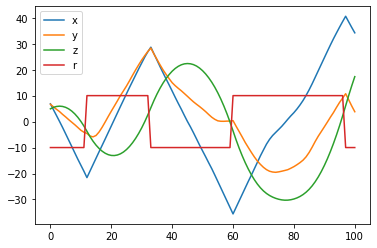

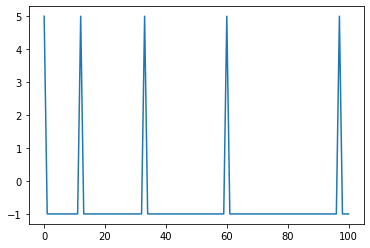

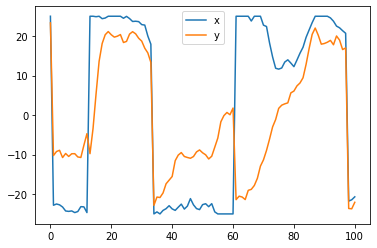

In [64]:
plt.plot(obs_hist)
plt.legend(['x', 'y', 'z', 'r'])

plt.figure()
plt.plot(reward_hist)

plt.figure()
plt.plot(action_hist)
plt.legend(['x', 'y'])

Text(0.5, 0.92, 'phase diagram')

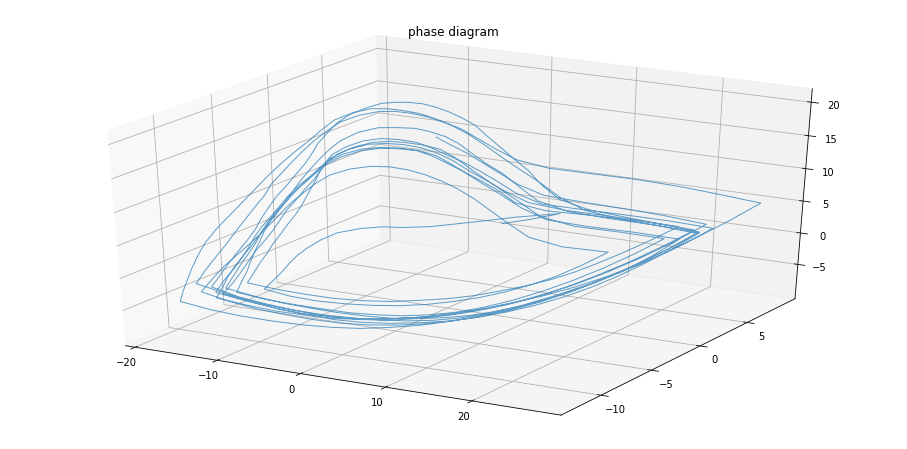

In [22]:
obs_arr = np.stack(obs_hist)

x = obs_arr[:,0]; y = obs_arr[:,1]; z = obs_arr[:,2]

fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
ax.plot(x,y,z, alpha=0.7, linewidth=1)
ax.set_title('phase diagram')


In [23]:
import pandas as pd
actions_smoothed = pd.DataFrame(obs_hist).rolling(5, min_periods=5).mean()


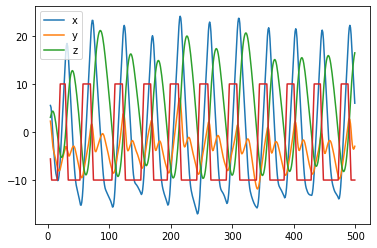

In [25]:
plt.plot(actions_smoothed)
plt.legend(['x', 'y', 'z'])

In [ ]:
actions_smoothed = pd.DataFrame(obs_hist).rolling(5, min_periods=5).mean()